In [1]:
from jupyterthemes import jtplot

jtplot.style(theme='monokai')

# A Neural Network that uses - JHU Data 
---

## What we will work with ?
---

Data will have all the county regions each representing a data point. <br>
Variables will be ranging from age groups to number of icu beds and ventilators. <br>
We want to see if this model can predict a state with given capacity, of becoming a next hotspot. <br>

# Perform Standard Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Let's create a model
---

## Finalized Layers : Leaky Relu
| L1 | L2 | L3 |
| -- | -- | -- |
| 144 | 44 | 20 |

In [3]:
l1 = input("Number of Layers in L 1 : ")
l2 = input("Number of Layers in L 2 : ")
l3 = input("Number of Layers in L 3 : ")
# n_iter = input("Number of Epochs : ")

l1 = int(l1)
l2 = int(l2)
l3 = int(l3)
# n_iter = int(n_iter)
n_iter = 18000

Number of Layers in L 1 : 144
Number of Layers in L 2 : 44
Number of Layers in L 3 : 20


In [4]:
class Model(nn.Module):
    def __init__(self, in_features=55, l1=l1, l2=l2, l3=l3, out_features=1):
        
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(in_features, l1)
        # hidden layer 1
        self.fc2 = nn.Linear(l1, l2)
        # hidden layer 2
        self.fc3 = nn.Linear(l2, l3)
        #output layer
        self.out = nn.Linear(l3, out_features)
        
          
    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        
        x = self.out(x)
        
        return x

# Pre-processing Dataset

In [5]:
train_d = pd.read_csv("../net_data/train_norm.csv")
test_d = pd.read_csv("../net_data/test_norm.csv")

train_d
test_d

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N47,N48,N49,N50,N51,N52,N53,N54,N55,N56
0,0.182109,0.015198,0.115868,0.209259,0.231156,0.430303,0.637253,0.011289,0.016361,0.016993,...,0.023667,0.011307,0.018064,0.016099,0.030679,0.015617,0.020173,0.001031,0.009898,313
1,0.000000,0.001910,0.000000,0.159259,0.130653,0.404816,0.000000,0.000000,0.000000,0.000000,...,0.007272,0.006751,0.008908,0.008338,0.015715,0.008334,0.010297,0.001024,0.012188,21
2,0.001645,0.325980,0.022446,0.494444,0.291457,0.291220,0.172896,0.000198,0.001165,0.001636,...,0.001141,0.001185,0.001774,0.001439,0.002729,0.001664,0.002233,0.000712,0.010893,608
3,0.000000,0.006453,0.000000,0.211111,0.185930,0.416858,0.637253,0.000000,0.004462,0.006393,...,0.003922,0.003143,0.005568,0.004479,0.008561,0.004639,0.006211,0.000932,0.009729,37
4,0.000000,0.002940,0.000000,0.225926,0.221106,0.303236,0.579774,0.000000,0.003591,0.004323,...,0.002076,0.001809,0.004100,0.002658,0.005082,0.002769,0.004788,0.001663,0.015679,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,0.000000,0.000000,0.000000,0.248148,0.271357,0.332443,0.368458,0.000000,0.000688,0.000873,...,0.000231,0.000143,0.000666,0.000316,0.000600,0.000326,0.000754,0.004230,0.027368,0
625,0.028902,0.015796,0.019113,0.229630,0.150754,0.378100,0.281501,0.001981,0.020024,0.019668,...,0.015435,0.014304,0.019756,0.017054,0.030906,0.016984,0.020760,0.000971,0.012276,346
626,0.000000,0.012652,0.000000,0.622222,0.351759,0.244965,0.497357,0.000000,0.000627,0.000250,...,0.000439,0.000227,0.000503,0.000439,0.000852,0.000461,0.000673,0.000715,0.011030,7
627,0.018349,0.014126,0.010851,0.251852,0.185930,0.352935,1.000000,0.000396,0.006321,0.007651,...,0.005463,0.004465,0.007614,0.006023,0.010782,0.005901,0.008184,0.001090,0.010479,109


In [6]:
X = train_d.iloc[:,0:55]
X

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,...,M46,M47,M48,M49,M50,M51,M52,M53,M54,M55
0,0.000000,0.031813,0.000000,0.177778,0.145729,0.352566,0.437168,0.000000,0.005783,0.005447,...,0.004180,0.003215,0.002734,0.005130,0.003625,0.006494,0.003537,0.004282,0.000968,0.009611
1,0.000000,0.007752,0.000000,0.174074,0.155779,0.500163,0.459412,0.000000,0.002231,0.002638,...,0.002583,0.002269,0.001716,0.002859,0.002577,0.004664,0.002752,0.003900,0.000356,0.009402
2,0.000000,0.013479,0.000000,0.151852,0.135678,0.400647,0.000000,0.000000,0.000000,0.000000,...,0.001749,0.001476,0.001184,0.002402,0.001716,0.003251,0.001775,0.002432,0.000861,0.010850
3,0.094017,0.031099,0.122404,0.374074,0.206030,0.288173,0.379110,0.002179,0.003796,0.003639,...,0.002746,0.002512,0.002045,0.004773,0.002960,0.005599,0.002997,0.004789,0.001261,0.011920
4,0.000000,0.000000,0.000000,0.251852,0.150754,0.292129,0.239002,0.000000,0.000894,0.000812,...,0.000246,0.000184,0.000170,0.000775,0.000278,0.000524,0.000265,0.000481,0.001758,0.013099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,0.000000,0.005782,0.000000,0.396296,0.326633,0.307370,0.472958,0.000000,0.004146,0.006918,...,0.002669,0.002848,0.001625,0.005403,0.003249,0.002705,0.003382,0.006697,0.003975,0.024867
2509,0.093333,0.018787,0.073407,0.327778,0.236181,0.351519,0.737403,0.001386,0.003702,0.003615,...,0.003563,0.002945,0.002491,0.003912,0.003109,0.005890,0.002980,0.003719,0.001021,0.015898
2510,0.069048,0.010347,0.029909,0.224074,0.221106,0.365329,0.459323,0.005744,0.051225,0.056659,...,0.027315,0.024577,0.021215,0.057256,0.030255,0.047817,0.029278,0.052778,0.000851,0.017779
2511,0.000000,0.000000,0.000000,0.385185,0.216080,0.269450,0.368458,0.000000,0.000905,0.000440,...,0.000911,0.000650,0.000517,0.000701,0.000659,0.001233,0.000574,0.000790,0.011177,0.042094


In [7]:
X_train = train_d.iloc[:,0:55]
X_train

y_train = train_d.iloc[:,55:56]
y_train


X_test = test_d.iloc[:,0:55]
X_test

y_test = test_d.iloc[:,55:56]
y_test

X_train

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,...,M46,M47,M48,M49,M50,M51,M52,M53,M54,M55
0,0.000000,0.031813,0.000000,0.177778,0.145729,0.352566,0.437168,0.000000,0.005783,0.005447,...,0.004180,0.003215,0.002734,0.005130,0.003625,0.006494,0.003537,0.004282,0.000968,0.009611
1,0.000000,0.007752,0.000000,0.174074,0.155779,0.500163,0.459412,0.000000,0.002231,0.002638,...,0.002583,0.002269,0.001716,0.002859,0.002577,0.004664,0.002752,0.003900,0.000356,0.009402
2,0.000000,0.013479,0.000000,0.151852,0.135678,0.400647,0.000000,0.000000,0.000000,0.000000,...,0.001749,0.001476,0.001184,0.002402,0.001716,0.003251,0.001775,0.002432,0.000861,0.010850
3,0.094017,0.031099,0.122404,0.374074,0.206030,0.288173,0.379110,0.002179,0.003796,0.003639,...,0.002746,0.002512,0.002045,0.004773,0.002960,0.005599,0.002997,0.004789,0.001261,0.011920
4,0.000000,0.000000,0.000000,0.251852,0.150754,0.292129,0.239002,0.000000,0.000894,0.000812,...,0.000246,0.000184,0.000170,0.000775,0.000278,0.000524,0.000265,0.000481,0.001758,0.013099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,0.000000,0.005782,0.000000,0.396296,0.326633,0.307370,0.472958,0.000000,0.004146,0.006918,...,0.002669,0.002848,0.001625,0.005403,0.003249,0.002705,0.003382,0.006697,0.003975,0.024867
2509,0.093333,0.018787,0.073407,0.327778,0.236181,0.351519,0.737403,0.001386,0.003702,0.003615,...,0.003563,0.002945,0.002491,0.003912,0.003109,0.005890,0.002980,0.003719,0.001021,0.015898
2510,0.069048,0.010347,0.029909,0.224074,0.221106,0.365329,0.459323,0.005744,0.051225,0.056659,...,0.027315,0.024577,0.021215,0.057256,0.030255,0.047817,0.029278,0.052778,0.000851,0.017779
2511,0.000000,0.000000,0.000000,0.385185,0.216080,0.269450,0.368458,0.000000,0.000905,0.000440,...,0.000911,0.000650,0.000517,0.000701,0.000659,0.001233,0.000574,0.000790,0.011177,0.042094


X_train = X.iloc[0:250, :]
X_test = X.iloc[250:300, :]

y_train = y.iloc[0:250, :]
y_test = y.iloc[250:300, :]

In [8]:
X_train = X_train.to_numpy(dtype=float)
X_test = X_test.to_numpy(dtype=float)

y_train = y_train.to_numpy(dtype=float)
y_test = y_test.to_numpy(dtype=float)
y_train

array([[148.],
       [ 26.],
       [ 30.],
       ...,
       [420.],
       [  0.],
       [129.]])

In [10]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)


y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

X_train

tensor([[0.0000, 0.0318, 0.0000,  ..., 0.0043, 0.0010, 0.0096],
        [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0004, 0.0094],
        [0.0000, 0.0135, 0.0000,  ..., 0.0024, 0.0009, 0.0109],
        ...,
        [0.0690, 0.0103, 0.0299,  ..., 0.0528, 0.0009, 0.0178],
        [0.0000, 0.0000, 0.0000,  ..., 0.0008, 0.0112, 0.0421],
        [0.0155, 0.0445, 0.0289,  ..., 0.0027, 0.0006, 0.0107]])

# Prepare DataLoader
---
For this analysis we don't need to create a Dataset object. <br>
But we should take advantage of PyTorch's DataLoader tool. <br>
Even though our dataset is small, we'll load it into our model in two batches. <br>
This technique becomes very helpful with large datasets.

In [11]:
trainloader = DataLoader(X_train, batch_size=100, shuffle=True)

testloader = DataLoader(X_test, batch_size=10, shuffle=False)

In [12]:
# For Redo
torch.manual_seed(44)
model = Model()

In [13]:
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
epochs = n_iter
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    loss1 = math.sqrt(math.sqrt(loss))
    losses.append(loss1)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():1.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 556.84857178
epoch: 11  loss: 556.76031494
epoch: 21  loss: 556.56628418
epoch: 31  loss: 556.08184814
epoch: 41  loss: 555.01507568
epoch: 51  loss: 552.94360352
epoch: 61  loss: 549.61846924
epoch: 71  loss: 545.34368896
epoch: 81  loss: 541.14727783
epoch: 91  loss: 538.55377197
epoch: 101  loss: 536.87103271
epoch: 111  loss: 534.82812500
epoch: 121  loss: 532.15869141
epoch: 131  loss: 528.53741455
epoch: 141  loss: 523.33544922
epoch: 151  loss: 515.79901123
epoch: 161  loss: 505.01144409
epoch: 171  loss: 490.39443970
epoch: 181  loss: 472.36346436
epoch: 191  loss: 451.26016235
epoch: 201  loss: 428.09957886
epoch: 211  loss: 406.81799316
epoch: 221  loss: 389.50772095
epoch: 231  loss: 374.78771973
epoch: 241  loss: 363.72479248
epoch: 251  loss: 355.70162964
epoch: 261  loss: 349.34375000
epoch: 271  loss: 344.52709961
epoch: 281  loss: 340.18148804
epoch: 291  loss: 335.87289429
epoch: 301  loss: 331.64764404
epoch: 311  loss: 327.56658936
epoch: 321  loss: 

epoch: 2651  loss: 44.67099380
epoch: 2661  loss: 44.37366867
epoch: 2671  loss: 44.01894379
epoch: 2681  loss: 43.99331284
epoch: 2691  loss: 43.74661255
epoch: 2701  loss: 43.73956299
epoch: 2711  loss: 43.43670273
epoch: 2721  loss: 43.60472488
epoch: 2731  loss: 43.20465088
epoch: 2741  loss: 43.13703918
epoch: 2751  loss: 42.93708801
epoch: 2761  loss: 42.87358093
epoch: 2771  loss: 42.67665482
epoch: 2781  loss: 42.62580109
epoch: 2791  loss: 42.55341721
epoch: 2801  loss: 42.29471588
epoch: 2811  loss: 42.27331924
epoch: 2821  loss: 42.17218018
epoch: 2831  loss: 41.95029831
epoch: 2841  loss: 41.95015335
epoch: 2851  loss: 41.69985580
epoch: 2861  loss: 41.71697235
epoch: 2871  loss: 41.40906143
epoch: 2881  loss: 41.41074753
epoch: 2891  loss: 41.37007904
epoch: 2901  loss: 41.12220383
epoch: 2911  loss: 41.10573578
epoch: 2921  loss: 40.97137833
epoch: 2931  loss: 41.02210236
epoch: 2941  loss: 40.64897537
epoch: 2951  loss: 40.71170807
epoch: 2961  loss: 40.97109604
epoch: 2

epoch: 5301  loss: 21.73551369
epoch: 5311  loss: 21.19026756
epoch: 5321  loss: 21.33228683
epoch: 5331  loss: 21.49957657
epoch: 5341  loss: 21.57679367
epoch: 5351  loss: 20.94215012
epoch: 5361  loss: 21.47082138
epoch: 5371  loss: 20.97931862
epoch: 5381  loss: 20.70077705
epoch: 5391  loss: 20.85502815
epoch: 5401  loss: 20.55341339
epoch: 5411  loss: 20.76567078
epoch: 5421  loss: 20.62777710
epoch: 5431  loss: 20.51550102
epoch: 5441  loss: 20.34437943
epoch: 5451  loss: 21.05286407
epoch: 5461  loss: 20.56466675
epoch: 5471  loss: 20.25483894
epoch: 5481  loss: 20.53743744
epoch: 5491  loss: 20.41560745
epoch: 5501  loss: 20.10083961
epoch: 5511  loss: 20.08451271
epoch: 5521  loss: 20.12141800
epoch: 5531  loss: 20.51655579
epoch: 5541  loss: 20.34745598
epoch: 5551  loss: 20.07822227
epoch: 5561  loss: 20.06516075
epoch: 5571  loss: 20.51456833
epoch: 5581  loss: 20.11437798
epoch: 5591  loss: 19.89754295
epoch: 5601  loss: 20.58119011
epoch: 5611  loss: 19.78322220
epoch: 5

epoch: 7951  loss: 13.99945164
epoch: 7961  loss: 14.38523102
epoch: 7971  loss: 14.07129192
epoch: 7981  loss: 14.00862694
epoch: 7991  loss: 14.34630108
epoch: 8001  loss: 13.81762028
epoch: 8011  loss: 13.90222549
epoch: 8021  loss: 14.35946560
epoch: 8031  loss: 13.80889416
epoch: 8041  loss: 14.31651974
epoch: 8051  loss: 13.72948170
epoch: 8061  loss: 14.64294243
epoch: 8071  loss: 14.07206154
epoch: 8081  loss: 13.77709198
epoch: 8091  loss: 13.59842682
epoch: 8101  loss: 13.93227100
epoch: 8111  loss: 14.30034161
epoch: 8121  loss: 13.71033287
epoch: 8131  loss: 14.30795002
epoch: 8141  loss: 14.10190487
epoch: 8151  loss: 13.56023407
epoch: 8161  loss: 13.49052429
epoch: 8171  loss: 13.58141708
epoch: 8181  loss: 14.12634468
epoch: 8191  loss: 13.89402580
epoch: 8201  loss: 14.07870674
epoch: 8211  loss: 13.79106617
epoch: 8221  loss: 13.73687744
epoch: 8231  loss: 13.53740978
epoch: 8241  loss: 13.40309811
epoch: 8251  loss: 13.75216961
epoch: 8261  loss: 13.42868328
epoch: 8

epoch: 10581  loss: 11.25848389
epoch: 10591  loss: 12.54505539
epoch: 10601  loss: 11.36167431
epoch: 10611  loss: 10.84690189
epoch: 10621  loss: 11.09469891
epoch: 10631  loss: 11.18447876
epoch: 10641  loss: 10.89876270
epoch: 10651  loss: 11.08966827
epoch: 10661  loss: 10.85373402
epoch: 10671  loss: 11.20979309
epoch: 10681  loss: 11.84099674
epoch: 10691  loss: 11.17387295
epoch: 10701  loss: 11.09166622
epoch: 10711  loss: 10.96731949
epoch: 10721  loss: 10.83612919
epoch: 10731  loss: 10.95726490
epoch: 10741  loss: 10.88340759
epoch: 10751  loss: 10.76618767
epoch: 10761  loss: 10.92162228
epoch: 10771  loss: 10.78440571
epoch: 10781  loss: 10.90722942
epoch: 10791  loss: 10.98931122
epoch: 10801  loss: 11.01843357
epoch: 10811  loss: 10.71041489
epoch: 10821  loss: 10.72511578
epoch: 10831  loss: 10.85872078
epoch: 10841  loss: 10.68813515
epoch: 10851  loss: 11.86343861
epoch: 10861  loss: 12.21619320
epoch: 10871  loss: 10.71647644
epoch: 10881  loss: 10.81636620
epoch: 1

epoch: 13191  loss: 9.68814850
epoch: 13201  loss: 8.92339611
epoch: 13211  loss: 9.10075855
epoch: 13221  loss: 9.16818619
epoch: 13231  loss: 8.96288204
epoch: 13241  loss: 8.87266350
epoch: 13251  loss: 10.19254303
epoch: 13261  loss: 9.63589478
epoch: 13271  loss: 9.34315014
epoch: 13281  loss: 9.78561497
epoch: 13291  loss: 9.86435223
epoch: 13301  loss: 9.54679775
epoch: 13311  loss: 9.69651890
epoch: 13321  loss: 9.58472443
epoch: 13331  loss: 9.47661304
epoch: 13341  loss: 9.47515583
epoch: 13351  loss: 9.85971737
epoch: 13361  loss: 9.33588982
epoch: 13371  loss: 9.36525345
epoch: 13381  loss: 9.33913422
epoch: 13391  loss: 9.47816944
epoch: 13401  loss: 9.45767879
epoch: 13411  loss: 9.51407337
epoch: 13421  loss: 9.25746250
epoch: 13431  loss: 9.36366653
epoch: 13441  loss: 9.30816746
epoch: 13451  loss: 8.70585728
epoch: 13461  loss: 8.88492680
epoch: 13471  loss: 8.70044327
epoch: 13481  loss: 8.67120552
epoch: 13491  loss: 8.72829342
epoch: 13501  loss: 8.65858078
epoch: 

epoch: 15841  loss: 7.88036108
epoch: 15851  loss: 7.67220449
epoch: 15861  loss: 7.93708563
epoch: 15871  loss: 7.72482777
epoch: 15881  loss: 7.41003561
epoch: 15891  loss: 7.46427107
epoch: 15901  loss: 8.13084888
epoch: 15911  loss: 8.69462109
epoch: 15921  loss: 7.46274900
epoch: 15931  loss: 8.15445614
epoch: 15941  loss: 7.80298996
epoch: 15951  loss: 8.54673862
epoch: 15961  loss: 7.68005514
epoch: 15971  loss: 7.84374619
epoch: 15981  loss: 7.74182844
epoch: 15991  loss: 7.53160906
epoch: 16001  loss: 7.52019262
epoch: 16011  loss: 8.23998356
epoch: 16021  loss: 7.35801888
epoch: 16031  loss: 8.03292847
epoch: 16041  loss: 7.82391119
epoch: 16051  loss: 7.37253618
epoch: 16061  loss: 7.28374386
epoch: 16071  loss: 7.52251720
epoch: 16081  loss: 7.45051575
epoch: 16091  loss: 7.36077261
epoch: 16101  loss: 7.19688940
epoch: 16111  loss: 7.82751560
epoch: 16121  loss: 7.89823675
epoch: 16131  loss: 7.97958279
epoch: 16141  loss: 7.42251301
epoch: 16151  loss: 7.32672071
epoch: 1

Text(0.5, 0, 'epoch')

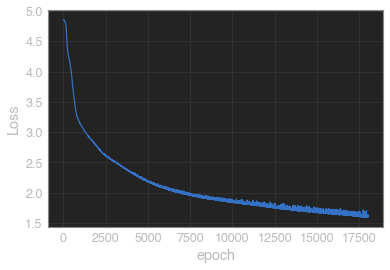

In [15]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [16]:
# TO EVALUATE THE ENTIRE TRAINING SET
with torch.no_grad():
    y_val = model(X_train)
    loss = torch.sqrt(criterion(y_val, y_train))
print(f'RMSE: {loss:.8f}')

RMSE: 2.56407905


## Validate the model
---
Here, we want to run the entire test set through the model, and compare it to the known value. <br>
For this step, we don't want to update weights and biases, so we set torch.no_grad()

In [17]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 7.42188597


In [18]:
# TO EVALUATE THE ENTIRE TRAINING SET
with torch.no_grad():
    y_val = model(X_train)
    loss = torch.sqrt(criterion(y_val, y_train))
print(f'RMSE: {loss:.8f}')

score = r2(y_train, y_val)
score

RMSE: 2.56407905


0.9998849923420362

In [19]:
## TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

score = r2(y_test, y_val)
score

RMSE: 7.42188597


0.952716285382386

# Plot : Test y-pred vs Test y-actual

torch.Size([629, 1])

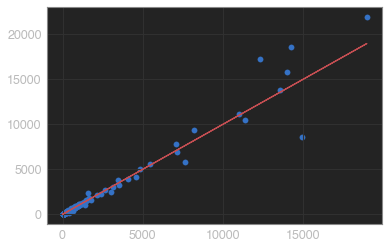

In [20]:
x = np.arange(0,629,1)
plt.scatter(y_val, y_test)
plt.plot(y_val,y_val, c='r')


y_val.shape
y_test.shape

# Final Plotting

RMSE: 2.56407905


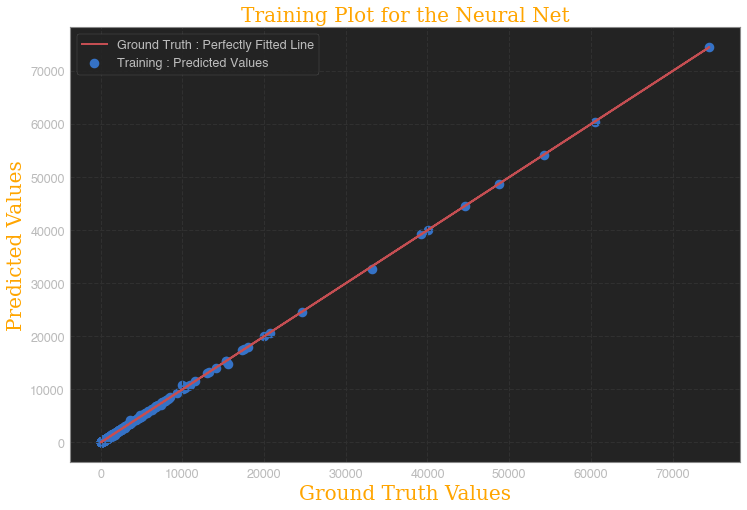

In [21]:
# TO EVALUATE THE ENTIRE TRAINING SET
with torch.no_grad():
    y_val = model(X_train)
    loss = torch.sqrt(criterion(y_val, y_train))
print(f'RMSE: {loss:.8f}')


font = {'family': 'serif',
        'color':  'orange',
        'weight': 'normal',
        'size': 20,
        }


plt.figure(figsize=(12,8))


x = np.arange(0,629,1)

plt.scatter(y_train, y_val, linewidth=4, label="Training : Predicted Values")

plt.plot(y_train,y_train, c='r', linewidth=2, label='Ground Truth : Perfectly Fitted Line' )

plt.grid(True,which="both", linestyle='--')


plt.xlabel('Ground Truth Values', fontdict=font) 
plt.ylabel('Predicted Values', fontdict=font)  
plt.legend(loc='best')

plt.title('Training Plot for the Neural Net', fontdict=font, fontsize=20)

plt.savefig("Training Plot.jpg",dpi=95)

RMSE: 7.42188597


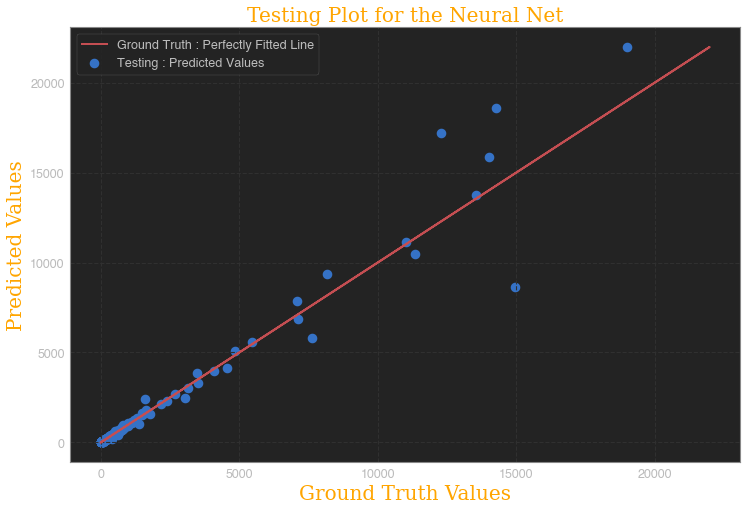

In [22]:
## TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(X_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')


font = {'family': 'serif',
        'color':  'orange',
        'weight': 'normal',
        'size': 20,
        }


plt.figure(figsize=(12,8))


x = np.arange(0,629,1)

plt.scatter(y_val, y_test,linewidth=4, label="Testing : Predicted Values")

plt.plot(y_test,y_test, c='r', linewidth=2, label='Ground Truth : Perfectly Fitted Line' )

plt.grid(True,which="both", linestyle='--')

plt.xlabel('Ground Truth Values', fontdict=font) 
plt.ylabel('Predicted Values', fontdict=font) 
plt.legend(loc='best')

plt.title('Testing Plot for the Neural Net', fontdict=font, fontsize=20)

plt.savefig("Testing Plot.jpg",dpi=95)

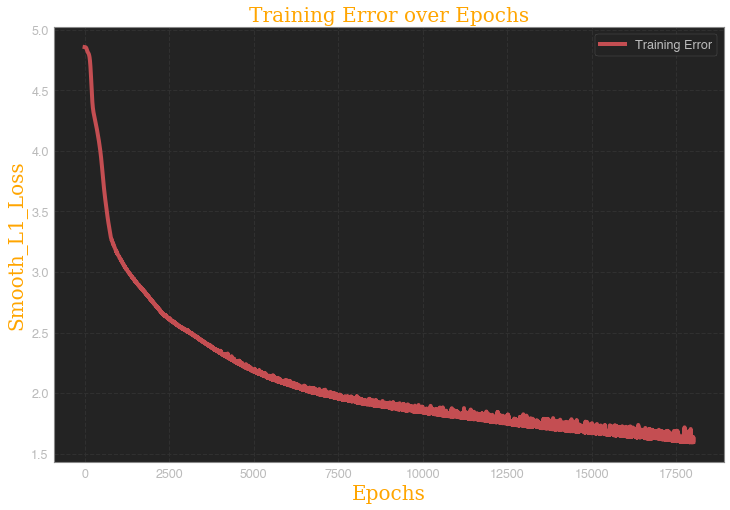

In [25]:
plt.figure(figsize=(12,8))

plt.plot(range(epochs), losses, linewidth=4, label="Training Error", c='r')

plt.grid(True,which="both", linestyle='--')

plt.xlabel('Epochs', fontdict=font) 
plt.ylabel('Smooth_L1_Loss', fontdict=font) 
plt.legend(loc='best')

plt.title('Training Error over Epochs', fontdict=font, fontsize=20)

plt.savefig("Training Error.jpg",dpi=95)